In [1]:
pip install keras==2.15.0

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 23.9 MB/s eta 0:00:00
  Attempting uninstall: keras
    Found existing installation: keras 3.2.1
    Uninstalling keras-3.2.1:
      Successfully uninstalled keras-3.2.1
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tensorflow-decision-forests 1.8.1 requires wurlitzer, which is not installed.
Note: you may need to restart the kernel to use updated packages.


In [2]:
# Importing dependencies

import os
import random
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import cv2
import warnings
warnings.filterwarnings('ignore')

import tensorflow as tf
from tensorflow.keras.layers import Layer
from tensorflow.keras.layers import *
import keras
from tensorflow.keras.callbacks import Callback

from sklearn.model_selection import train_test_split

from sklearn.metrics import mean_squared_error, classification_report, confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import accuracy_score, f1_score,RocCurveDisplay

SEED = 42
IMG_SIZE = 224, 224
BATCH_SIZE = 32
AUTO = tf.data.AUTOTUNE

2024-06-04 15:43:34.860906: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-06-04 15:43:34.861006: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-06-04 15:43:34.984751: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [3]:
# creating main dataframe contains image paths and their classes.

def create_images_list(path):
    full_path = []
    images = sorted(os.listdir(path))
    for i in images:
        full_path.append(os.path.join(path, i))
    return full_path


classes = {0: 'Benign', 1: 'Malignant'}

train_benign_imgs = create_images_list('/kaggle/input/melanoma-cancer-dataset/train/Benign')
train_malignant_imgs = create_images_list('/kaggle/input/melanoma-cancer-dataset/train/Malignant')

full_data = pd.concat([pd.DataFrame({'image' : train_benign_imgs, 'label': 0 }),
                      pd.DataFrame({'image' : train_malignant_imgs, 'label': 1 })])
# shuffling dataset
full_data = full_data.sample(frac = 1, ignore_index = True, random_state = SEED)

# train and valid splitting
train_data, valid_data = train_test_split(full_data, test_size = 0.2, stratify = full_data['label'])

train_data = train_data.reset_index(drop = True)
valid_data = valid_data.reset_index(drop = True)

# test dataframe
test_benign_imgs = create_images_list('/kaggle/input/melanoma-cancer-dataset/test/Benign')
test_malignant_imgs = create_images_list('/kaggle/input/melanoma-cancer-dataset/test/Malignant')

test_data = pd.concat([pd.DataFrame({'image' : test_benign_imgs, 'label': 0 }),
                       pd.DataFrame({'image' : test_malignant_imgs, 'label': 1 })])
test_data = test_data.sample(frac = 1, ignore_index = True, random_state = SEED)


print('total train images \t{0}'.format(train_data.shape[0]))
print('total valid images \t{0}'.format(valid_data.shape[0]))
print('total test images \t{0}'.format(test_data.shape[0]))

total train images 	9503
total valid images 	2376
total test images 	2000


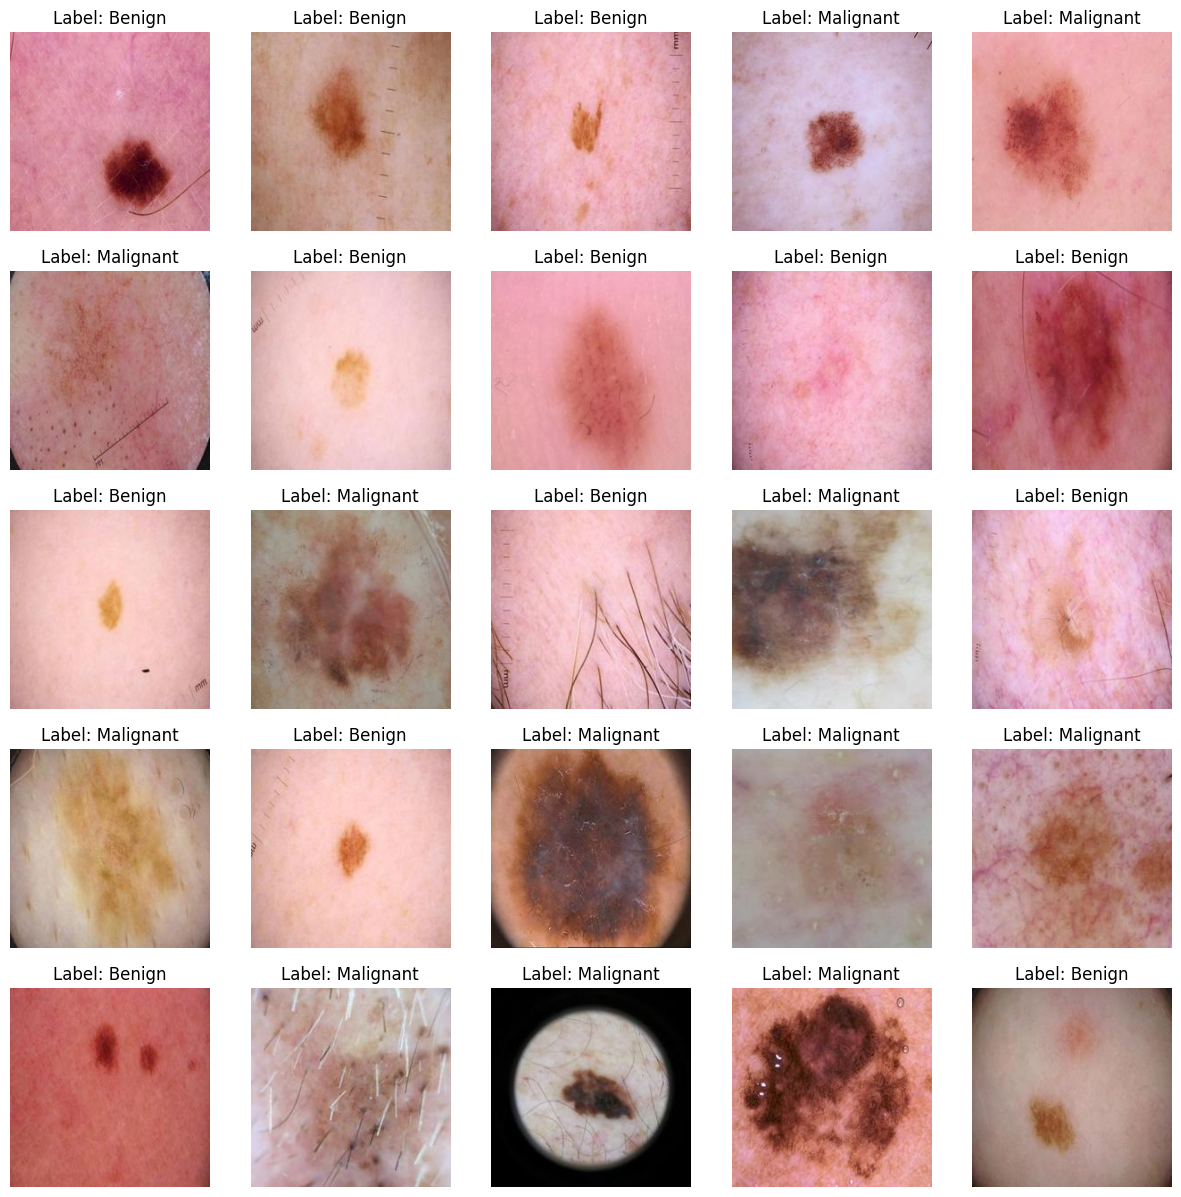

In [4]:
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image

# Print 25 random samples from the training data with inferno colormap
plt.figure(figsize=(15, 15))

for i in range(25):
    ax = plt.subplot(5, 5, i+1)
    random_index = np.random.randint(0, train_data.shape[0])
    img_path = train_data.loc[random_index, 'image']
    img = Image.open(img_path)
    plt.imshow(img)
    ax.set_title(f"Label: {classes[train_data.loc[random_index, 'label']]}")
    ax.axis('off')

plt.show()

In [5]:
# Reading -> Resizing -> Normalization
def img_preprocessing(image, label):
    img = tf.io.read_file(image)
    img = tf.io.decode_png(img, channels = 3)
    img = tf.image.resize(img, size =(IMG_SIZE))
    img = tf.cast(img, tf.float32) / 255.0


    return img, label


# Data augmentation
img_augmentation = tf.keras.Sequential([
    RandomFlip("horizontal_and_vertical"),
    RandomRotation((-0.3, 0.3), interpolation="bilinear"),
    RandomContrast(0.03),
    RandomCrop(*IMG_SIZE)])

In [6]:
# Creating dataset loaders and tf.datasets

train_loader = tf.data.Dataset.from_tensor_slices((train_data['image'], train_data['label']))
train_dataset = (train_loader
                 .map(img_preprocessing, num_parallel_calls = AUTO)
                 .shuffle(BATCH_SIZE*10)
                 .batch(BATCH_SIZE)
                 .map(lambda img, label: (img_augmentation(img), label), num_parallel_calls =AUTO)
                 .prefetch(AUTO))


valid_loader = tf.data.Dataset.from_tensor_slices((valid_data['image'], valid_data['label']))
valid_dataset = (valid_loader
                 .map(img_preprocessing, num_parallel_calls = AUTO)
                 .batch(BATCH_SIZE)
                 .prefetch(AUTO))

test_loader = tf.data.Dataset.from_tensor_slices((test_data['image'], test_data['label']))
test_dataset = (test_loader
                 .map(img_preprocessing, num_parallel_calls = AUTO)
                 .batch(BATCH_SIZE)
                 .prefetch(AUTO))

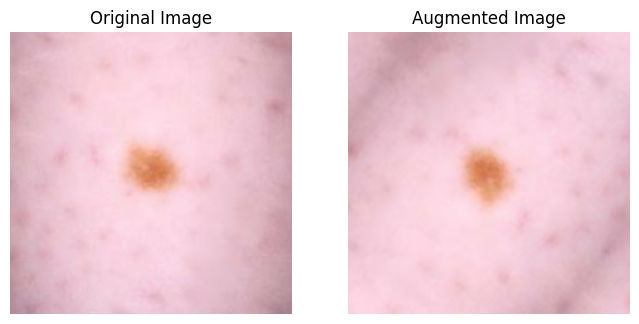

In [7]:
# Display original and augmented image for the first sample
def display_sample_images(dataset):
    for images, labels in dataset.take(1):
        # Display original image
        original_image = images[0].numpy()
        
        # Apply augmentation
        augmented_image = img_augmentation(images[0:1], training=True)[0].numpy()
        
        # Plotting
        plt.figure(figsize=(8, 4))
        
        # Original image
        plt.subplot(1, 2, 1)
        plt.title("Original Image")
        plt.imshow(original_image,cmap='inferno')
        plt.axis("off")
        
        # Augmented image
        plt.subplot(1, 2, 2)
        plt.title("Augmented Image")
        plt.imshow(augmented_image,cmap='inferno')
        plt.axis("off")
        
        plt.show()
        break

# Display original and augmented images from train dataset
display_sample_images(train_dataset)

In [8]:
# a custom callback for evaluation of test set during training each 10 loop
class Test_Pred_During_Training(Callback):

    def __init__(self, model):
        self._model = model

    def on_epoch_end(self, epochs, logs = None ):
        try:
            if (epochs+1) % 10 == 0:
                test_pred = self.model.predict(test_dataset, verbose = 0)
                test_pred = np.argmax(test_pred, axis = 1)

                mse = mean_squared_error(test_data['label'], test_pred)
                f1 = f1_score(test_data['label'], test_pred, average = 'weighted')
                acc = accuracy_score(test_data['label'], test_pred)

                print('\nMean Squared Error : {0:.5f}'.format(mse))
                print('Weighted F1 Score : {0:.3f}'.format(f1))
                print('Accuracy Score : {0:.3f} %'.format(acc*100))

                print("--"*40)
        except ValueError:
            pass

In [9]:
import tensorflow as tf
import numpy as np
from tensorflow import keras
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.applications import ConvNeXtBase
from tensorflow.keras import models
from tensorflow.keras import layers

In [10]:
base_model = ConvNeXtBase(
    model_name='convnext_base',
    include_top=False,
    weights='imagenet',
    input_shape=(224, 224, 3),
    classes=2,
    classifier_activation='softmax'
)

for layer in base_model.layers:
    layer.trainable = False

for layer in base_model.layers[-4:]:
    layer.trainable = True

# Create a new model on top
model = models.Sequential()
model.add(base_model)
model.add(layers.GlobalAveragePooling2D())
model.add(layers.Dense(512, activation='relu'))
model.add(layers.Dropout(0.4))
model.add(layers.Dense(256, activation='relu'))
model.add(layers.Dropout(0.3))
model.add(layers.Dense(128, activation='relu'))
model.add(layers.Dropout(0.3))
model.add(layers.Dense(2, activation='softmax'))

350926856/350926856 [==============================] - 2s 0us/step


In [11]:
initial_learning_rate = 0.001
lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate, decay_steps=1000, decay_rate=0.9
)
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=lr_schedule), 
                    loss= tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True), 
                    metrics=['accuracy'])

In [12]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 convnext_base (Functional)  (None, 7, 7, 1024)        87566464  
                                                                 
 global_average_pooling2d (  (None, 1024)              0         
 GlobalAveragePooling2D)                                         
                                                                 
 dense (Dense)               (None, 512)               524800    
                                                                 
 dropout (Dropout)           (None, 512)               0         
                                                                 
 dense_1 (Dense)             (None, 256)               131328    
                                                                 
 dropout_1 (Dropout)         (None, 256)               0         
                                                      

In [13]:
# from tensorflow.keras.utils import plot_model
# # Explore model visually
# plot_model(
#     model, dpi=60,
#     show_shapes=True
# )

In [14]:
my_callbacks = [Test_Pred_During_Training(model),
                tf.keras.callbacks.ReduceLROnPlateau(monitor = 'val_loss',factor=0.1, min_delta = 0.01, patience=6),
#                 tf.keras.callbacks.EarlyStopping(monitor = 'val_loss', min_delta = 0.01,patience=20),
                tf.keras.callbacks.ModelCheckpoint("/kaggle/working/my_model.tf", monitor="val_loss", mode="min", save_best_only=True, verbose=1)]

In [15]:
import time
start = time.time()
history = model.fit(
    train_dataset,
    batch_size=32,
    epochs=50,
    validation_data=valid_dataset,
    callbacks=[my_callbacks]
)
print("Total time: ", time.time() - start, "seconds")

Epoch 1/50


I0000 00:00:1717515862.380223      78 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


297/297 [==============================] - ETA: 0s - loss: 0.6843 - accuracy: 0.5627
Epoch 1: val_loss improved from inf to 0.63944, saving model to /kaggle/working/my_model.tf
297/297 [==============================] - 186s 547ms/step - loss: 0.6843 - accuracy: 0.5627 - val_loss: 0.6394 - val_accuracy: 0.6023 - lr: 9.6929e-04
Epoch 2/50
297/297 [==============================] - ETA: 0s - loss: 0.6447 - accuracy: 0.5978
Epoch 2: val_loss improved from 0.63944 to 0.63236, saving model to /kaggle/working/my_model.tf
297/297 [==============================] - 150s 504ms/step - loss: 0.6447 - accuracy: 0.5978 - val_loss: 0.6324 - val_accuracy: 0.6103 - lr: 9.3943e-04
Epoch 3/50
297/297 [==============================] - ETA: 0s - loss: 0.6338 - accuracy: 0.6157
Epoch 3: val_loss improved from 0.63236 to 0.62731, saving model to /kaggle/working/my_model.tf
297/297 [==============================] - 151s 506ms/step - loss: 0.6338 - accuracy: 0.6157 - val_loss: 0.6273 - val_accuracy: 0.6141 

In [16]:
# Print training results
print("Training Results:")
print("Loss:", history.history['loss'][-1])
print("Accuracy:", history.history['accuracy'][-1])
print("Validation Loss:", history.history['val_loss'][-1])
print("Validation Accuracy:", history.history['val_accuracy'][-1])

Training Results:
Loss: 0.42478370666503906
Accuracy: 0.800273597240448
Validation Loss: 0.44547039270401
Validation Accuracy: 0.7769360542297363


Loss: Train Loss = 0.4248, Validation Loss = 0.4455


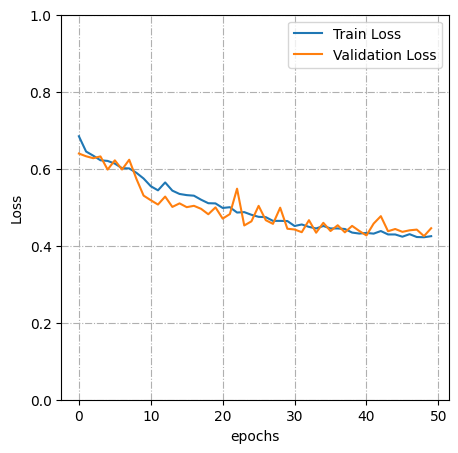

In [17]:
fig, axs = plt.subplots(1, 1, figsize=(5, 5), dpi=100)

axs.grid(linestyle='dashdot')
axs.plot(history.history['loss'])
axs.plot(history.history['val_loss'])
axs.set_xlabel('epochs', fontsize=10)
axs.set_ylabel('Loss', fontsize=10)
axs.legend(['Train Loss', 'Validation Loss'], fontsize=10)
axs.set_ylim(0, 1)
print(f'Loss: Train Loss = {history.history["loss"][-1]:.4f}, Validation Loss = {history.history["val_loss"][-1]:.4f}')

Accuracy: Train Accuracy = 0.8003, Validation Accuracy = 0.7769


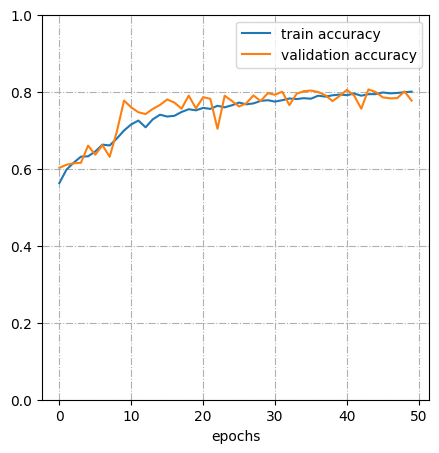

In [18]:
fig, axs = plt.subplots(1,1, figsize = (5, 5), dpi = 100)
axs.grid(linestyle = 'dashdot')
axs.plot(history.history['accuracy'])
axs.plot(history.history['val_accuracy'])
axs.set_xlabel('epochs', fontsize = 10)
axs.legend(['train accuracy', 'validation accuracy'], fontsize = 10)
axs.set_ylim(0, 1)
print(f'Accuracy: Train Accuracy = {history.history["accuracy"][-1]:.4f}, Validation Accuracy = {history.history["val_accuracy"][-1]:.4f}')

In [19]:
# Predictions and scores
test_pred = model.predict(test_dataset)
test_pred = np.argmax(test_pred, axis = 1)

mse = mean_squared_error(test_data['label'], test_pred)
f1 = f1_score(test_data['label'], test_pred, average = 'weighted')
acc = accuracy_score(test_data['label'], test_pred)

print('Mean Squared Error : {0:.5f}'.format(mse))
print('Weighted F1 Score : {0:.3f}'.format(f1))
print('Accuracy Score : {0:.3f} %'.format(acc*100))

63/63 [==============================] - 20s 316ms/step
Mean Squared Error : 0.29850
Weighted F1 Score : 0.686
Accuracy Score : 70.150 %


In [20]:
clf = classification_report(test_data['label'], test_pred, target_names = list(classes.values()))
print(clf)

              precision    recall  f1-score   support

      Benign       0.64      0.93      0.76      1000
   Malignant       0.87      0.48      0.62      1000

    accuracy                           0.70      2000
   macro avg       0.75      0.70      0.69      2000
weighted avg       0.75      0.70      0.69      2000



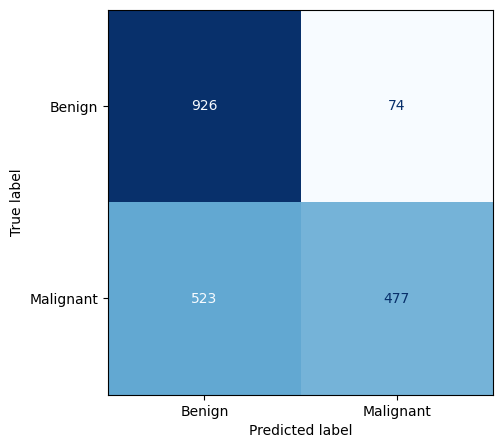

In [21]:
cm = confusion_matrix(test_data['label'], test_pred)
cmd = ConfusionMatrixDisplay(cm, display_labels = list(classes.values()))

fig, ax = plt.subplots(figsize=(5,5))
cmd.plot(ax=ax,  cmap = 'Blues', colorbar = False)

In [22]:
# Evaluate the model on the test set
test_loss, test_acc = model.evaluate(test_dataset)

# Print test results
print("\nTest Results:")
print("Test Loss:", test_loss)
print("Test Accuracy:", test_acc)

63/63 [==============================] - 20s 319ms/step - loss: 0.5261 - accuracy: 0.7015

Test Results:
Test Loss: 0.5261481404304504
Test Accuracy: 0.7014999985694885


63/63 [==============================] - 20s 319ms/step - loss: 0.5261 - accuracy: 0.7015
Test Loss: 0.5261481404304504
Test Accuracy: 0.7014999985694885
Test time: 20.510857343673706 seconds


(0.0, 1.0)

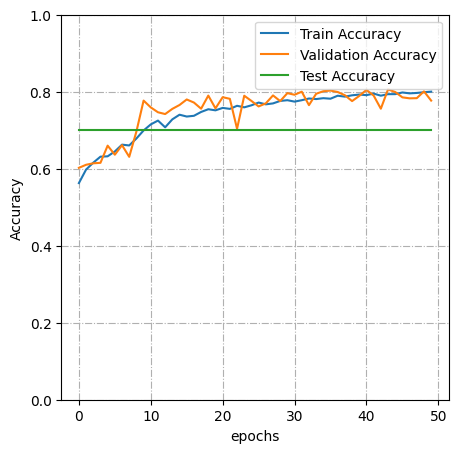

In [23]:
# Thử nghiệm trên tập kiểm thử
start_time = time.time()
test_loss, test_acc = model.evaluate(test_dataset)
test_time = time.time() - start_time

print("Test Loss:", test_loss)
print("Test Accuracy:", test_acc)
print("Test time:", test_time, "seconds")

# Vẽ biểu đồ độ chính xác kiểm thử
fig, axs = plt.subplots(1, 1, figsize=(5, 5), dpi=100)
axs.grid(linestyle='dashdot')
axs.plot(history.history['accuracy'])
axs.plot(history.history['val_accuracy'])
axs.plot([test_acc] * len(history.history['accuracy'])) # Sử dụng test_acc, không phải val_acc
axs.set_xlabel('epochs', fontsize=10)
axs.set_ylabel('Accuracy', fontsize=10)
axs.legend(['Train Accuracy', 'Validation Accuracy', 'Test Accuracy'], fontsize=10)
axs.set_ylim(0, 1)

In [24]:
test_take1 =  test_dataset.take(-1)
test_take1_ = list(test_take1)

# A function that creating 5 random images in the test set and predictions

# Red title -> a false prediction
# Green title -> a true prediction

def random_test_sample_with_prediction(SEED):
    idxs = np.random.default_rng(seed=SEED).permutation(len(test_pred))[:5]
    batch_idx = idxs // BATCH_SIZE
    image_idx = idxs - batch_idx * BATCH_SIZE
    idx = idxs

    fig, axs = plt.subplots(1, 5, figsize=(12, 12), dpi=150)

    for i in range(5):
        img = test_take1_[batch_idx[i]][0][image_idx[i]]
        label = test_take1_[batch_idx[i]][1][image_idx[i]].numpy()
        pred = model.predict(tf.expand_dims(img, axis=0))[0]
        pred_label = np.argmax(pred)  # Lấy nhãn dự đoán có xác suất cao nhất
        pred_prob = pred[pred_label]  # Xác suất của nhãn dự đoán

        if pred_label == label:
            axs[i].imshow(img, cmap='gray')
            axs[i].axis('off')
            axs[i].set_title(f'image (no: {idx[i]})\nTRUE: {classes[label]}\nPRED: {classes[pred_label]} ({pred_prob:.2%})', fontsize=8, color='green')
        else:
            axs[i].imshow(img, cmap='gray')
            axs[i].axis('off')
            axs[i].set_title(f'image (no: {idx[i]})\nTRUE: {classes[label]}\nPRED: {classes[pred_label]} ({pred_prob:.2%})', fontsize=8, color='red')

1/1 [==============================] - 0s 55ms/step


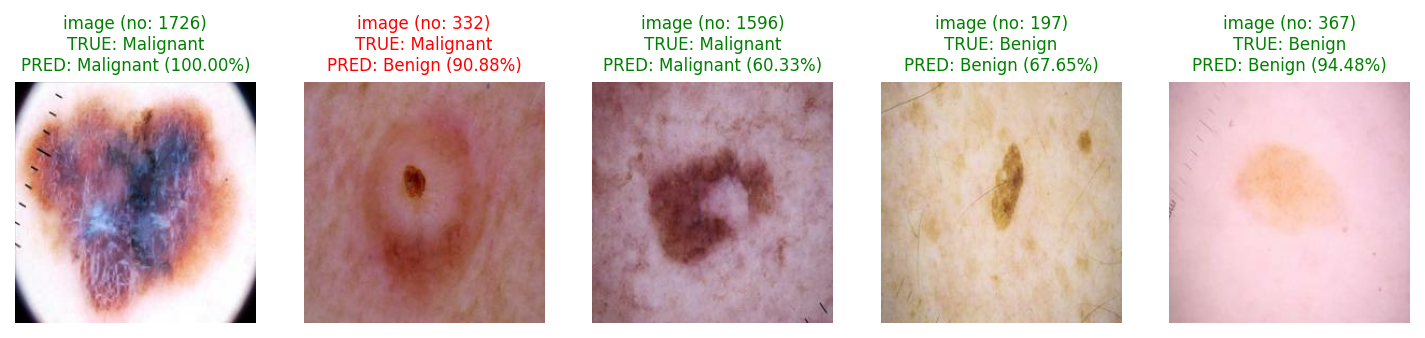

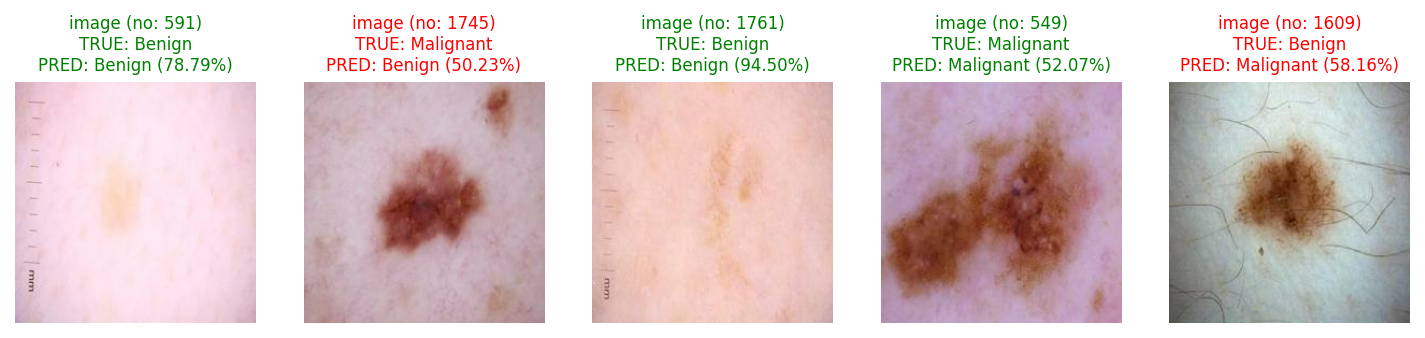

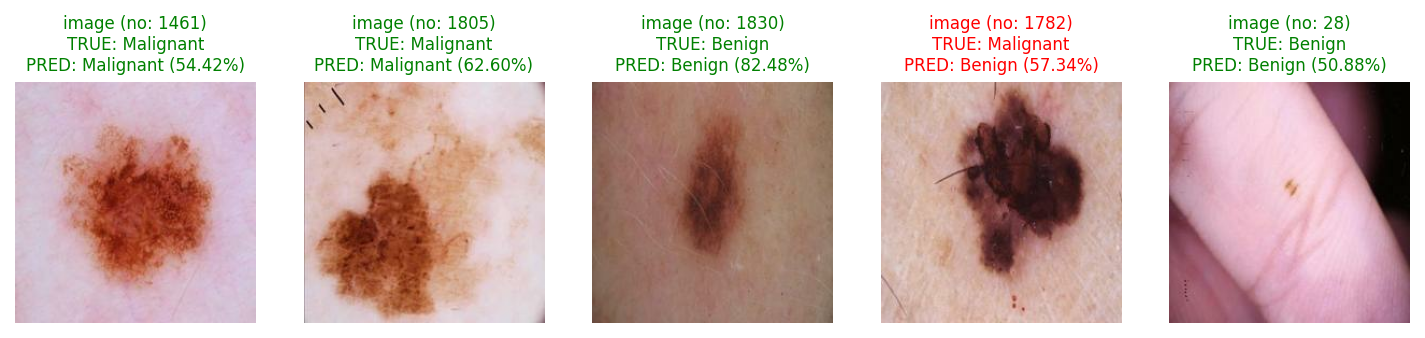

In [25]:
# Red title -> a false prediction
# Green title -> a true prediction

random_test_sample_with_prediction(21)
random_test_sample_with_prediction(204)
random_test_sample_with_prediction(293)

In [26]:
loaded_model = tf.keras.models.load_model('/kaggle/working/my_model.tf')

1/1 [==============================] - 6s 6s/step


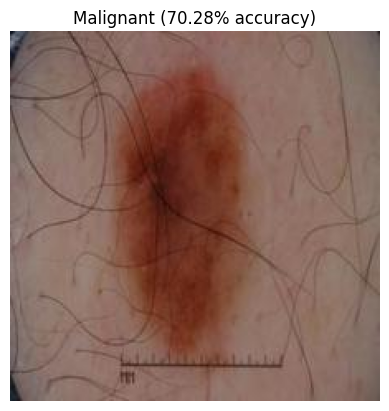

In [27]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
# 5742
test_image_path = '/kaggle/input/melanoma-cancer-dataset/test/Malignant/5742.jpg'

test_image = cv2.imread(test_image_path)
test_image = cv2.resize(test_image, (224, 224))
test_image_display = cv2.cvtColor(test_image, cv2.COLOR_BGR2RGB)
test_image_normalized = test_image / 255.0
test_image_normalized = np.expand_dims(test_image_normalized, axis=0)

predictions = loaded_model.predict(test_image_normalized)
predicted_class_index = np.argmax(predictions)
if predicted_class_index == 0:
    predicted_class = 'Benign'
else:
    predicted_class = 'Malignant'

predicted_accuracy = np.max(predictions) *100

# if predicted_class_index == 1:
#     bounding_box = [50, 70, 150, 120]
#     cv2.rectangle(test_image_display, (bounding_box[0], bounding_box[1]), (bounding_box[2], bounding_box[3]), (0, 255, 0), 2)

plt.imshow(test_image_display)
plt.title(f"{predicted_class} ({predicted_accuracy:.2f}% accuracy)")
plt.axis('off')
plt.show()